# Tech-Challenge - Cleaning

You are given a dataset coming from one of the banks. The dataset is available here: https://drive.google.com/file/d/1XAC-bK29qppHwQHrwVGBa4yCH6ocD7iL/view?usp=sharing. It contains information about customers, their accounts, credit cards, loans taken and transactions. A comprehensive explanation of the dataset and particular attributes can be accessed here (https://sorry.vse.cz/~berka/challenge/pkdd1999/berka.htm).  Please make yourself familiar with the data model and have a look over the data files.

## Cleaning / Preparation
Our transactional dataset (“trans” table) was just delivered to you from a different department where it was put together from different sources. You would like to make sure that the data is clean and ready for using it in the production database. Please fix the problems in the dataset before you start the analytical jobs to get a good result!

So lets see what 'trans.csv' (df_trans) is about. Under https://sorry.vse.cz/~berka/challenge/pkdd1999/berka.htm you find the following description of trans.csv:

relation transaction (1056320 objects in the file TRANS.ASC) - each record describes one transaction on an account

In [1]:
import numpy as np
import pandas as pd
import datetime
import pickle

In [2]:
# Read in the csv files
path_to_files = 'data/'

df_account = pd.read_csv(path_to_files+'account.csv', sep=';')
df_card = pd.read_csv(path_to_files+'card.csv', sep=';')
df_client = pd.read_csv(path_to_files+'client.csv', sep=';')
df_disp = pd.read_csv(path_to_files+'disp.csv', sep=';')
df_district = pd.read_csv(path_to_files+'district.csv', sep=';')
df_loan = pd.read_csv(path_to_files+'loan.csv', sep=';')
df_order = pd.read_csv(path_to_files+'order.csv', sep=';')
df_trans = pd.read_csv(path_to_files+'trans.csv', sep=';')

In [5]:
df_trans.head(10)

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,branch,bank,account
0,967842,1532,1998-05-31,PRIJEM,NaN,253,62661,UROK,AR,NaN,0
1,271012,1499,1998-01-09,PRIJEM,VKLAD,5500,49790,NaN,AR,NaN,0
2,971490,1645,1996-11-30,PRIJEM,NaN,43,19460,UROK,AR,NaN,0
3,605699,3366,1996-10-28,VYDAJ,VYBER,9300,38433,NaN,AR,NaN,0
4,443107,2471,1998-07-30,VYDAJ,VYBER,7800,56237,NaN,AR,NaN,0
5,627433,3503,1995-06-07,VYDAJ,VYBER,28640,41949,NaN,AR,NaN,0
6,390740,2162,1997-12-03,PRIJEM,VKLAD,11111,38640,NaN,AR,NaN,0
7,516014,2861,1997-01-13,VYDAJ,PREVOD NA UCET,2613,25692,SIPO,AR,GH,70139986
8,321504,1782,1994-04-30,VYDAJ,VYBER,960,25793,NaN,AR,NaN,0
9,329984,1823,1997-02-05,PRIJEM,PREVOD Z UCTU,4941,25705,DUCHOD,AR,CD,91663467


In [5]:
df_trans.describe()

,trans_id,account_id,amount,balance,account
count,1.056410e+06,1.056410e+06,1.056410e+06,1.056410e+06,1.056410e+06
mean,5.282038e+05,2.937625e+03,5.924133e+03,3.851928e+04,1.277152e+07
std,3.049588e+05,2.478601e+03,9.522339e+03,2.211902e+04,2.613622e+07
min,1.000000e+00,1.000000e+00,0.000000e+00,-4.112600e+04,0.000000e+00
25%,2.640972e+05,1.205000e+03,1.360000e+02,2.240300e+04,0.000000e+00
50%,5.282055e+05,2.434000e+03,2.100000e+03,3.314400e+04,0.000000e+00
75%,7.923048e+05,3.660000e+03,6.800000e+03,4.960500e+04,3.410566e+06
max,1.056406e+06,1.237600e+04,8.740000e+04,2.096370e+05,9.999420e+07


The shape of the dataframe is

In [6]:
df_trans.shape

(1056410, 11)

The datatypes present are

In [7]:
df_trans.dtypes

trans_id       int64
account_id     int64
date          object
type          object
operation     object
amount         int64
balance        int64
k_symbol      object
branch        object
bank          object
account        int64
dtype: object

### Missing values

In [8]:
for column in df_trans.columns:
    nan_sum = df_trans[column].isnull().sum()
    print('Column {} \t {} missing values ({:.2f}%).'.format(column, nan_sum, nan_sum/df_trans.shape[0]*100))

Column trans_id 	 0 missing values (0.00%).
Column account_id 	 0 missing values (0.00%).
Column date 	 0 missing values (0.00%).
Column type 	 0 missing values (0.00%).
Column operation 	 183126 missing values (17.33%).
Column amount 	 0 missing values (0.00%).
Column balance 	 0 missing values (0.00%).
Column k_symbol 	 535359 missing values (50.68%).
Column branch 	 0 missing values (0.00%).
Column bank 	 782875 missing values (74.11%).
Column account 	 0 missing values (0.00%).


### Check for duplicate rows.
There are none

In [9]:
df_trans.duplicated().sum()

0

### Distribution of values
A good way to get a feeling for the values is to use histogram plots. The withdrawel amount and balance are both right skewed as expexted. I expected the account_id to be evenly distributed (or declining linearly, because higher account_id could mean newer account and therefore less time to do transactions), but it seems account IDs with a lower ID-number (< 4000) are more likely to do transactions. I guess this has to do with the dataset being a demo dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6a4580b50>,
      dtype=object)

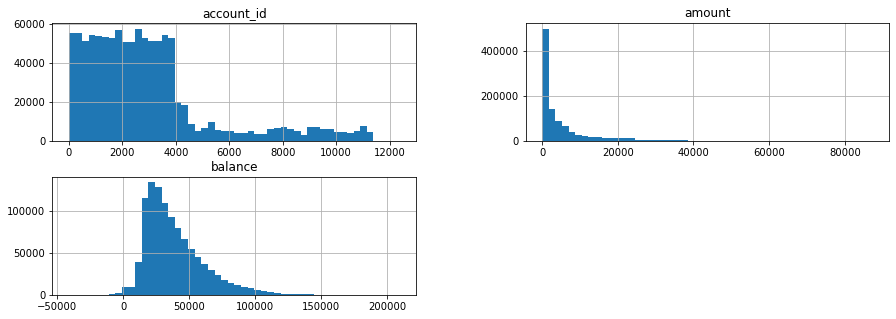

In [10]:
df_trans[['account_id','amount','balance']].hist(bins=50, figsize=(15,5))

### Checking through the variables

In [11]:
df_trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,branch,bank,account
0,967842,1532,1998-05-31,PRIJEM,NaN,253,62661,UROK,AR,NaN,0
1,271012,1499,1998-01-09,PRIJEM,VKLAD,5500,49790,NaN,AR,NaN,0
2,971490,1645,1996-11-30,PRIJEM,NaN,43,19460,UROK,AR,NaN,0
3,605699,3366,1996-10-28,VYDAJ,VYBER,9300,38433,NaN,AR,NaN,0
4,443107,2471,1998-07-30,VYDAJ,VYBER,7800,56237,NaN,AR,NaN,0


#### trans_id - issue 1
The column 'trans_id' is a record identifier and the entries should therefore be unique for every row. But when comparing the length of the dataframe and the number of unique 'trans_id' values we see that the shapes don't match.

In [12]:
df_trans.shape[0], len(df_trans.trans_id.unique()) # # of rows > # unique trans_id values

(1056410, 1056398)

The duplicate values trans_id values are

In [13]:
df_trans.trans_id[df_trans.trans_id.duplicated()]

313087     971227
464422     139687
513695     685100
669645     412937
697803     685101
826414     139684
836795     139688
847869     685102
937446     139686
967566     139689
1021339    139685
1041488    412938
Name: trans_id, dtype: int64

Because we are not interested in recalculating every transaction it seems reasonable to drop 12 lines out of more than a million

In [14]:
# drop follwing rows with duplicate trans_id entry
df_trans.drop_duplicates(subset='trans_id', keep = 'first', inplace = True) 
df_trans.shape[0] == len(df_trans.trans_id.unique())

True

#### account_id - issue 2
account_id is the account, the transation deals with. So it can occur multiple times. But lets see if all of the account ids in the trans table are present in the account table df_account.

In [15]:
unique_trans_account_id = df_trans.account_id.unique() # unique account_id in df_trans
unique_account_id = df_account.account_id.unique() # unique account_id in df_account
# which df_trans.account_id are not in df_account.account_id
mask = np.isin(unique_trans_account_id, unique_account_id, invert = True) # compare two numpy arrays
useless_ids = unique_trans_account_id[mask] # ids, which are only present in df_trans and not in df_account
print('There are', len(unique_trans_account_id[mask]), 'account_id in df_trans, which are not present in df_account.')
useless_ids

There are 86 account_id in df_trans, which are not present in df_account.


array([12120, 11977, 11991, 11896, 11652, 11815, 11835, 12116, 11587,
       11665, 11622, 12148, 11462, 11795, 12157, 11639, 12376, 11536,
       11438, 11875, 11429, 11616, 11985, 11799, 12132, 12246, 11705,
       11833, 11513, 11501, 11994, 11797, 11529, 11646, 12336, 12153,
       12159, 11416, 11620, 12217, 12100, 11805, 12139, 11483, 12196,
       11626, 11597, 12252, 11945, 11727, 12059, 12042, 11573, 11906,
       11592, 11715, 11591, 11526, 11712, 11928, 11391, 11503, 11720,
       12293, 12349, 11631, 11915, 12296, 11551, 12010, 12164, 11877,
       11827, 11737, 11419, 11469, 12110, 11993, 11553, 12230, 11588,
       11389, 12001, 11500, 11661, 11790])

So 86 account_id values are not in the account table. I seems useless to have account IDs which are not registered in the account table. So I guess we can drop them, because only 90 transactions (rows) are affected by this.

In [16]:
# number of transactions with account_id, which are not in the account table
df_trans[df_trans.account_id.isin(useless_ids)].shape[0]

90

In [17]:
# drop those rows withaccount_id, which are not in the account table
df_trans = df_trans[~df_trans.account_id.isin(useless_ids)]
df_trans.shape # new shape

(1056308, 11)

#### Dates - issue 3
Dates are imported as string. I wanted to convert them into dates, but got this error (ValueError: time data 1996-31-12 doesn't match format specified). According to the documentation dates are written in the form YYMMDD (actually it is YYYY-MM-DD). But some are stored in the order YYYY-DD-MM.

Obviously wrong dates are the ones with month > 12. It is easy to convert those into the right format by switching month and day. This is not the fastest way to change day and month, but it gets the job done.

In [18]:
a=[]
counter=0
for d in df_trans['date']:
    if int(d[5:7]) > 12:
        d = d[0:5]+d[-2:]+d[4:7]  # put together the string in the right order
        counter += 1 # count how often that happens
    a.append(pd.to_datetime(d, format='%Y-%m-%d'))
df_trans['date_new'] = a
print('The date had to be corrected',counter,'times.')

The date had to be corrected 3140 times.


But because the dates are not ordered, it is not possible to see which dates with day (month) < 13 are wrong. We can just make a guess.

- I assume dates with wrong formats and transaction dates are evenly distributed.
- There are 221 dates a year where the day value is >12. ((31-12) 7+4 (30-12)+28-12, leap year not considered), this is 60.55%
- df_trans lists 1056410 transactions. According to my assumptions 1056410 * 0.6055 = 639635 of those transactions happened when day > 12.
- Above I counted how often I had to correct the obviously wrong dates, which was counter = 3141. This is 3141 / 639635 * 100 = 0.49%
- Therefore I assume that there are still 1056410 (1-0.6055) 0.0049 = 2046 transactions whose date has day < 13 and day and month are switched (date is wrong), but which I can not correct.

#### type - issue 4
"type" marks what kind of transaction took place. According to documentation "PRIJEM" stands for credit, "VYDAJ" stands for withdrawal. That´s it. Except...its not.

In [19]:
df_trans.type.unique()

array(['PRIJEM', 'VYDAJ', 'VYBER', 'PRJIEM'], dtype=object)

When checking the unique values it appears that there are two more entries:
- VYBER, which stand for "withdrawal in cash" in the column operations. I therefore convert it to VYDAY, which stands for general withdrawal
- PRJIEM, which seems to be a typo. So I convert it to PRIJEM

In [20]:
df_trans.type.replace(to_replace='VYBER', value = 'VYDAJ', inplace=True)
df_trans.type.replace(to_replace='PRIJEM', value = 'PRJIEM', inplace=True)

#### operation
"operation" stands for mode of transaction. There should be 5 different entries: "VYBER KARTOU", "VKLAD", "PREVOD Z UCTU", "VYBER" and "PREVOD NA UCET"

In [21]:
df_trans.operation.unique()

array([nan, 'VKLAD', 'VYBER', 'PREVOD NA UCET', 'PREVOD Z UCTU',
       'VYBER KARTOU'], dtype=object)

The entries themselves are ok, but the problem here are the 183126 missing values (17.33%) of the dataset, which can not be filled.

#### amount and balance
Amount and balance are two of the most important parameters here and they have both no missing values. But there are 162 transactions with an amount of 0. This should be checked, if there is an error.

In [22]:
df_trans['amount'][df_trans['amount']==0].count()

162

#### k_symbol
k_symbol stands for the characterization of the transaction, with 7 different strings

In [23]:
df_trans.k_symbol.unique()

array(['UROK', nan, 'SIPO', 'DUCHOD', 'SLUZBY', 'POJISTNE', 'UVER',
       'SANKC. UROK'], dtype=object)

The values are ok, but again, there are 535359 missing values (50.68%) in the original dataset

#### bank and account
bank states the bank of the partner with a two letter code. There are 782875 missing values (74.11%) in the original dataset. account is the account of the partner, which is "0" when the "bank" value is missing.

#### Save the Dataframe

In [24]:
df_trans.to_pickle(path_to_files+'trans_cleaned.pkl')